In [1]:
#@title Configuration
from google.colab import drive
import os
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"


Mounted at /content/drive


In [2]:
#@title Initialization { display-mode: "both" }
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark

In [3]:
#@title Common Imports
from pyspark import SparkContext, SparkConf
import sys
import json
import pyspark.sql.functions as F
sc = SparkContext.getOrCreate()
from pyspark.sql.window import Window
import matplotlib.pyplot as plt
import numpy as np

from ipywidgets import widgets
from IPython.display import display

File path, Folder ID, Constants and other related information

In [4]:
#@title File path, Folder ID, Constants
drivepath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVData"
driveDAILYpath = "/content/drive/Shareddrives/ProjectSharedDrive/wazirxCSVCumulative"
DayofW = ["Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"]


In [5]:
#@title Load Coin names from the tickers file
fileRef = open(driveDAILYpath+"/USDTCoinName.txt" ,"r")
coinName = []
coinCode = []
for lines in fileRef:
  name = eval(lines[:-1])
  coinName.append(name[1])
  coinCode.append(name)

## **Interactive Display for Transaction Trend Analysis**

Choose the coin to start processing

In [6]:
#@title Select the Coin

coin = widgets.Dropdown(
    options=coinName,
    value=coinName[0],
    description='Select Coin: ',
    disabled=False,
)

display(coin)


Dropdown(description='Select Coin: ', options=('Tether', 'Bitcoin', 'TRON', 'XRP', 'EOS', 'Ethereum', 'ICON', …

Processing the selected coin. Run the next columns for output

In [26]:
#@title Fetching the Coin Name

coinChosen = [item for item in coinCode if item[1] == coin.value]
print(coinChosen[0][0])

snxusdt


In [27]:
#@title Select Frequency
TTIVal = ["HOURLY", "DAILY", "MONTHLY" ]
TTI = widgets.Dropdown(
    options=TTIVal,
    value=TTIVal[0],
    description='Select Frequency: ',
    disabled=False,
)
display(TTI)

Dropdown(description='Select Frequency: ', options=('HOURLY', 'DAILY', 'MONTHLY'), value='HOURLY')

In [30]:
#@title Performing Trend Analysis
coinChosen = [item for item in coinCode if item[1] == coin.value]
Freq = TTI.value

if Freq == TTIVal[0]:
  coinfile = driveDAILYpath+"/"+coinChosen[0][0]+Freq+".csv"
else:
  coinfile = driveDAILYpath+"/"+coinChosen[0][0]+"DAILY.csv"


p0 = spark.read.option("header",True).option("inferSchema",True).csv(coinfile)

#Hourly
if Freq == TTIVal[0]:
  p2 = p0.drop("_c0").withColumn('Day', F.split(F.col("Date"), " ")[0])
  window = Window.partitionBy('Day')
  p3 = p2.withColumn('maxHigh', F.max('Volume').over(window))\
      .where(F.col('Volume') == F.col('maxHigh'))\
      .drop('maxHigh')

  p4 = p3.withColumn('Time', F.split(F.col("Date"), " ")[1]).drop('Day')
  p5 = p4.groupBy('Time').agg(F.count(F.col('Time')).alias("Frequency")).orderBy('Time')
  OUTPUT = p5.select("Time", "Frequency")

#Daily
if Freq == TTIVal[1]:
  p2 = p0.drop("_c0").withColumn('Day', F.dayofweek(F.col("Date"))).withColumn('Week', F.weekofyear(F.col("Date")))
  #p2.show()
  window = Window.partitionBy('Week')
  p3 = p2.withColumn('maxHigh', F.max('Volume').over(window))\
      .where(F.col('Volume') == F.col('maxHigh'))\
      .drop('maxHigh')
  p4 = p3.groupBy('Day').agg(F.count(F.col('Day')).alias("Frequency")).orderBy('Day')
  OUTPUT = p4.select("Day", "Frequency")

#Monthly
if Freq == TTIVal[2]:
  p2 = p0.drop("_c0").withColumn('DayNum', F.split(F.col("Date"), "-")[2]).withColumn('Month', F.month(F.col("Date")))

  window = Window.partitionBy('Month')
  p3 = p2.withColumn('maxHigh', F.max('Volume').over(window))\
      .where(F.col('Volume') == F.col('maxHigh'))\
      .drop('maxHigh')
  #p3.show()
  p4 = p3.groupBy('DayNum').agg(F.count(F.col('DayNum')).alias("Frequency")).orderBy('DayNum')
  OUTPUT = p4.select("DayNum", "Frequency")


## **Interactive Display for Transaction Trend Analysis**


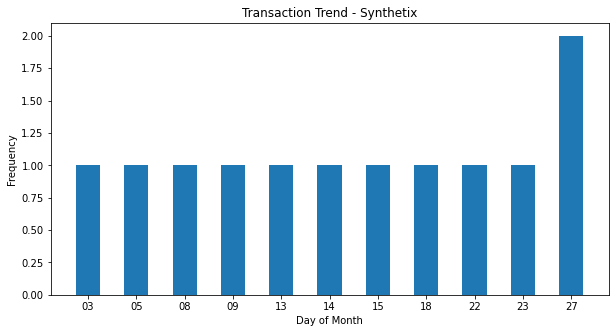

In [31]:
#@title Create the Graph

if Freq == TTIVal[0]:
  xval = OUTPUT.rdd.map(lambda x: x[0][:2]).collect()
  plt.xlabel("Hour")
elif Freq == TTIVal[1]:
  xval = DayofW
  plt.xlabel("Day of Week")
elif Freq == TTIVal[2]:
  xval = OUTPUT.rdd.map(lambda x: x[0]).collect()
  plt.xlabel("Day of Month")



yval = OUTPUT.rdd.map(lambda x: x[1]).collect()
#print(xval)
#f = plt.figure()
#f.set_figwidth(200)
#f.set_figheight(100)
plt.bar(xval, yval, width=0.5)
#plt.xlabel(Freq)
plt.ylabel("Frequency")
plt.rcParams["figure.figsize"] = (10,5)
#plt.legend(loc="upper right")
plt.title("Transaction Trend - "+ coin.value)


#plt.xticks(xval[::200])
plt.show()